In [1]:
import os
import pandas as pd
import numpy as np
import subprocess as sp
import glob
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from upsetplot import plot, UpSet
import gffutils

In [2]:
input_path = os.path.join("/data/processing1/leily/deseq_pairwise/") #deseq2 result
output_path = os.path.join("/data/processing1/leily/deseq_pairwise/fdr0.05")

In [3]:
# the following cell needs to be run once, only if db is not generated

In [4]:
# # Making a database from the gtf file
# gtf_file = os.path.join("/data/repository/organisms/GRCm38_ensembl/gencode/m9/genes.gtf")
# db = gffutils.create_db(gtf_file,
#                         dbfn = os.path.join(output_path, "grcm38.db"),
#                         disable_infer_transcripts=True,
#                         disable_infer_genes=True)

In [5]:
# Add UP/DOWN column
for file in glob.glob(os.path.join(input_path,"ddr*tsv")):
    df = pd.read_csv(file, sep = "\t", header = None, skiprows = 1)
    df.rename(columns={0: "gene_id", 1: "baseMean", 2: "log2FoldChange", 3: "lfcSE", 4: "stat",
                       5: "pvalue", 6: "padj"}, inplace = True)
    df["up/down"] = np.nan
    df.loc[(df["log2FoldChange"] > 0) & (df["padj"] < 0.05), "up/down"] = "UP"
    df.loc[(df["log2FoldChange"] < 0) & (df["padj"] < 0.05), "up/down"] = "DOWN"
    df = df.sort_values(by = "padj", ascending = True)
    name = os.path.basename(file).split(".tsv")[0]+".filtered.tsv"
    df.to_csv(os.path.join(output_path, name), index = False, sep = "\t", na_rep='NaN')

In [6]:
# # all expressed genes within a time point
# for time in ['lps0', 'lps3', 'lps12']:
#     pattern = "ddr_"+time+"*"+time+"*tsv"
#     files = []
#     for file in glob.glob(os.path.join(output_path, pattern)):
#         name = os.path.basename(file)
#         first = name.split("_")[2]
#         if first != "shctrl":
#             continue
#         print(name)
#         df = pd.read_csv(file, sep = "\t", na_values = "NaN")
#         df = df.loc[df["up/down"].astype(str) != 'nan']
#         print(len(df))
#         files.append(df)
#     merged_df = files[0].merge(files[1], on = "gene_id", how = 'outer')
#     print(len(merged_df))
#     merged_df = merged_df["gene_id"]
#     merged_df.to_csv(os.path.join(output_path, "all_expressed_genes_in_"+time+".txt"),
#                      index = False, sep = "\t", header = None)


In [7]:
# per time point

lps0_shctrl_vs_shprdx1
2850
3442
lps0_shctrl_vs_shmof
2469
2964
lps3_shctrl_vs_shmof
3478
3725
lps3_shctrl_vs_shprdx1
3471
4032
lps12_shctrl_vs_shprdx1
3299
3222
lps12_shctrl_vs_shmof
1991
3093


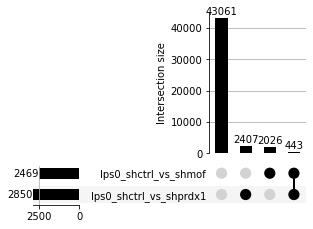

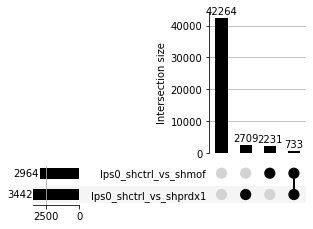

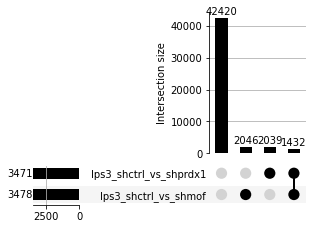

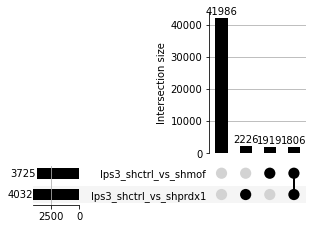

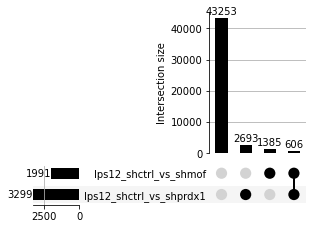

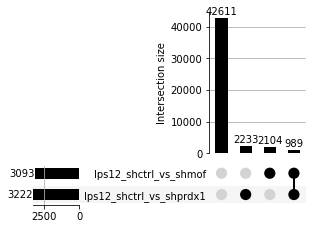

In [8]:
for time in ['lps0', 'lps3', 'lps12']:
    pattern = "ddr_"+time+"*"+time+"*tsv"
    dge_up = pd.DataFrame()
    dge_down = pd.DataFrame()
    all_diffs = pd.DataFrame()
    names = []
    i = 0
    for file in glob.glob(os.path.join(output_path, pattern)):
        name = os.path.basename(file).split(".filter")[0]
        first = name.split("_")[2]
        if first != "shctrl":
            continue
        second = name.split("_")[4]
        name = "{}_{}_vs_{}".format(time, first, second)
        names.append(name)
        df = pd.read_csv(file, sep = "\t", usecols =["gene_id","up/down"])
        df.rename(columns = {"up/down": name}, inplace = True)
        print(name)
        print(len(df.loc[df[name]=="UP"]))
        print(len(df.loc[df[name]=="DOWN"]))
        df_up = df.copy()
        df_down = df.copy()
        # up
        df_up.loc[df_up[name] == "UP", name] = True
        df_up.loc[df_up[name] == "DOWN", name] = False
#         df_up = df_up.fillna(False)
        # down
        df_down.loc[df_down[name] == "UP", name] = False
        df_down.loc[df_down[name] == "DOWN", name] = True
#         df_down = df_down.fillna(False)
        if i == 0:
            dge_up = df_up.copy()
            dge_down = df_down.copy()
            all_diffs = df
        else:
            dge_up = dge_up.merge(df_up, on = "gene_id", how = 'outer')
            dge_down = dge_down.merge(df_down, on = "gene_id", how = 'outer')
            all_diffs = all_diffs.merge(df, on = "gene_id", how = 'outer')
            
        i = i + 1
        
    # save up and down df
    to_save_up = dge_up.copy()
    to_save_up.replace({True: "UP", False: "DOWN"}, inplace = True)
    to_save_up.dropna(how = 'any', inplace = True)
    to_save_up.to_csv(os.path.join(output_path,time+"_up_n_down.tsv"), sep = "\t", index = None, na_rep='NaN')
#   to_save_up.dropna(subset = to_save_up.columns[1:], how = 'all', inplace = True)
    
    all_diffs.to_csv(os.path.join(output_path,time+"_all_diffs.tsv"), sep = "\t", index = None, na_rep='NaN')

    
    dge_up = dge_up.fillna(False)
    dge_up = dge_up.set_index(names)
    dge_down = dge_down.fillna(False)
    dge_down = dge_down.set_index(names)
    plot(dge_up, subset_size='count' , show_counts='%d')
    current_figure = plt.gcf()
    current_figure.savefig(os.path.join(output_path,"UP_"+time+".png"))
    
    plot(dge_down, subset_size='count', show_counts='%d')
    current_figure = plt.gcf()
    current_figure.savefig(os.path.join(output_path,"DOWN_"+time+".png"))
    

In [9]:
db = gffutils.FeatureDB(os.path.join(output_path, "grcm38.db"))

In [10]:
# Add gene name
for time in ['lps0', 'lps3', 'lps12']:
    pattern = "ddr_"+time+"*"+time+"*tsv"
    df = pd.read_csv(os.path.join(output_path,time+"_up_n_down.tsv"),
                     sep = "\t")
    names = []
    print(len(df))
    for index, row in df.iterrows():
        gene_id = row['gene_id']
        try:
            gene = db[gene_id]
            name = gene.attributes['gene_name']
            names.append(name[0])
        except:
            print("name not found!")
            names.append("no_name")
    df['gene_name'] = names
    df.to_csv(os.path.join(output_path,time+"_up_n_down.tsv"), sep = "\t", index = None)
    print(len(names))

3132
3132
4659
4659
3029
3029


In [11]:
# upset plot to show all genes which were differentially expressed in both condition of a time point 

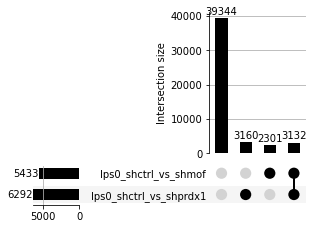

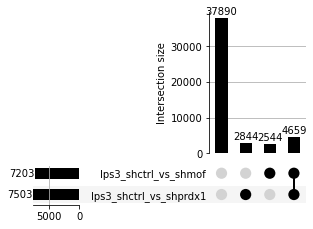

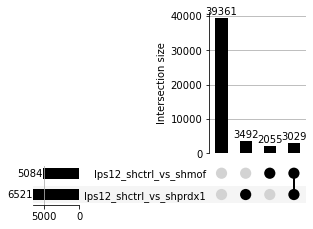

In [12]:
for time in ['lps0', 'lps3', 'lps12']:
    for file in glob.glob(os.path.join(output_path,time+"_all_diffs.tsv")):
        df = pd.read_csv(file, sep = "\t", na_values=np.nan)
        df.replace('UP', True, inplace= True)
        df.replace('DOWN', True, inplace= True)
        df.fillna(False, inplace = True)
        cols = [i for i in df.columns[1:]]
        df.set_index(cols, inplace=True)
        plot(df, subset_size='count' , show_counts='%d')
        current_figure = plt.gcf()
        current_figure.savefig(os.path.join(output_path,"all_diffs_"+time+".png"))

In [13]:
# for time in ['lps0', 'lps3', 'lps12']:
#     for file in glob.glob(os.path.join(output_path,time+"_all_diffs.tsv")):
#         df = pd.read_csv(file, sep = "\t", na_values=np.nan)
#         cols = [i for i in df.columns[1:]]
#         df.loc[(df[cols[0]] == "UP") & (df[cols[1]] == "UP"), [cols[0], cols[1]]] = True
#         df.loc[(df[cols[0]] == "DOWN") & (df[cols[1]] == "DOWN"), [cols[0], cols[1]]] = True
#         df.loc[(df[cols[0]] != True ) & (df[cols[1]] == "DOWN"), [cols[0], cols[1]]] = True
#         print(df)